In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils.multiclass import unique_labels

In [3]:
# get features
df = pd.read_csv(datapath)

# get labels
labelpath = r"C:\Users\Alvin\Desktop\UT\fall2019\research project\dep final proj\dep_QIDS.csv"
df_label = pd.read_csv(labelpath)

In [4]:
# get percent improvement at week 8 and classified into two groups using 0.5 improvement as boundary 
# 1 means significant improvement, and 0 means insignificant improvement

df_label = df_label[df_label.Available.isna()==False]
df_label["improve_ratio"] = (df_label["QIDS at BL"] - df_label["QIDS week 8"])/df_label["QIDS at BL"]
df_label = df_label.reset_index(drop=True)
df_label["improve_0.5"] = "na"
for i in range(0, len(df_label.improve_ratio)):
    if df_label.improve_ratio[i] < 0.5:
         df_label["improve_0.5"][i] = 0
    else:
        df_label["improve_0.5"][i] = 1
df_label["improve_0.5"] = df_label["improve_0.5"].astype('int32')
df_label

C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Alvin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Record ID,QIDS at BL,QIDS week 8,Available,resid_wk4,resid_wk8,resid_wk12,improve_ratio,improve_0.5
0,217,17,7.0,1.0,-6.886655,-2.629953,2.863476,0.588235,1
1,287,19,13.0,1.0,1.001742,1.810611,NaN,0.315789,0
2,464,16,14.0,1.0,5.669147,5.149765,11.483375,0.125000,0
3,518,20,14.0,1.0,1.445941,2.030893,5.003778,0.300000,0
4,591,16,10.0,1.0,2.669147,1.149765,NaN,0.375000,0
5,751,16,3.0,1.0,-4.330853,-5.850235,-5.516625,0.812500,1
6,911,18,6.0,1.0,-0.442456,-4.409671,-3.756423,0.666667,1
7,924,18,6.0,1.0,-6.442456,-4.409671,-6.756423,0.666667,1
8,942,10,2.0,1.0,-1.996044,-2.171927,-2.797229,0.800000,1
9,1055,18,14.0,1.0,-0.442456,3.590329,NaN,0.222222,0


In [5]:
# merge features and labels, for following prediction, improve_0.5 is used as label (change to whatever label you want to use in future)

df_label1 = df_label[["Record ID", "improve_0.5"]]
df=pd.merge(df, df_label1, left_on="Record Id", right_on="Record ID")
df.drop("Record ID", axis=1, inplace=True)
df

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mel_freq5_delta,mel_freq6_delta,mel_freq7_delta,mel_freq8_delta,pitch_delta,magnitude_delta,chroma_ener_avg_delta,zero_cross_rate_delta,Record Id,improve_0.5
0,-239.513574,41.694798,-82.011085,4.159306,-12.262586,13.796800,-20.637196,-11.622997,-10.768946,-0.292671,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1055,0
1,-222.830583,44.980201,-88.716640,6.502889,-13.369073,11.668922,-14.730706,-2.892193,-12.370176,-3.898755,...,2.450231,2.375752,0.265836,0.417316,-2.965858,0.001603,0.0,0.092285,1055,0
2,-225.960080,44.627084,-86.704187,13.712355,-11.861403,12.516545,-16.499868,-4.538289,-5.684513,-1.809459,...,0.774059,-0.152957,0.950297,-0.926956,9.925484,0.007144,0.0,0.006836,1055,0
3,-231.875804,39.466115,-90.979345,11.988355,-10.363558,11.358681,-18.076440,-7.534345,-11.069544,-5.553638,...,-0.730104,-0.416340,-0.288132,-0.294116,6.850777,-0.000061,0.0,-0.012207,1055,0
4,-227.746126,45.558285,-80.698413,4.879035,-6.688264,13.411695,-20.171685,-9.879432,-11.794359,1.723916,...,-1.442556,-1.583658,-1.096247,1.376421,-3.608429,-0.005250,0.0,-0.003906,1055,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155018,-372.276641,47.548032,-30.203254,-25.752518,-16.700279,-10.932835,-2.112484,9.207634,-3.155421,-1.011040,...,-4.275318,1.563752,0.526786,2.031052,0.300339,-0.007094,0.0,0.072754,942,1
155019,-388.398529,31.397903,-18.074681,-1.713849,4.097436,2.533372,-1.639686,7.187384,0.759382,2.823090,...,-3.299556,0.053653,0.731613,1.149718,18.158752,-0.002491,0.0,0.062988,942,1
155020,-385.396880,32.815732,-22.384682,-2.983271,5.517545,-0.660358,-10.002551,-0.875990,-3.691017,4.477122,...,0.596227,0.219163,-0.156057,-0.466582,0.840759,0.000218,0.0,-0.013672,942,1
155021,-372.955878,28.373612,-18.130649,10.565806,8.053597,15.701506,-6.494263,-2.287263,-2.120863,-7.124207,...,1.212428,1.812421,4.998411,1.263253,-16.037369,0.000175,0.0,0.022949,942,1


In [6]:
# inspect if label balanced
label_count = df.groupby("improve_0.5").size()
label_count

improve_0.5
0    90037
1    64986
dtype: int64

In [7]:
x = df[df.columns[df.columns!="improve_0.5"] & df.columns[df.columns!="Record Id"]].values
y = df["improve_0.5"].values
print(x.shape)
print(y.shape)

(155023, 50)
(155023,)


In [8]:
# scaling or standardization data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# scaler = MinMaxScaler()
std = StandardScaler()
x_sca = std.fit_transform(x)

In [9]:
# leave one participant out 
logo = LeaveOneGroupOut()
groups = df["Record Id"]

In [10]:
# create logistic regression model

proba=[]
num_features=50
coef=np.zeros([1,num_features])
y_new=[]

for train_index, test_index in logo.split(x_sca, y, groups):
    clf = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter=500, random_state=0)
    x_train, x_test = x_sca[train_index], x_sca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(x_train, y_train)
    coef = coef + clf.coef_
    proba.append(list(clf.predict_proba(x_test)[:,1]))
    y_new.append(list(y_test))

record_id = list(df["Record Id"].unique())[1:] + list(df["Record Id"].unique())[:1]
avg_coef = coef / len(record_id)

In [11]:
# get individual participant level prediction results in a dataframe

avg_proba = [np.mean(i) for i in proba]
y_new = [np.mean(i) for i in y_new]
y_pred = []
for i in avg_proba:
    if i > 0.5:
        y_pred.append(1.0)
    else:
        y_pred.append(0)

In [12]:
pred_re = pd.DataFrame(list(zip(avg_proba, y_pred, y_new, record_id)), columns = ["avg_proba", "pred_0.5", "improve_0.5", "Record ID"])
pred_re = pred_re.merge(df_label[["improve_ratio","Record ID"]], on="Record ID")
pred_re

,avg_proba,pred_0.5,improve_0.5,Record ID,improve_ratio
0,0.610246,1.0,1.0,217,0.588235
1,0.863626,1.0,0.0,287,0.315789
2,0.477333,0.0,0.0,464,0.125000
3,0.647101,1.0,0.0,518,0.300000
4,0.429627,0.0,0.0,591,0.375000
5,0.060675,0.0,1.0,751,0.812500
6,0.527757,1.0,1.0,911,0.666667
7,0.342920,0.0,1.0,924,0.666667
8,0.518773,1.0,1.0,942,0.800000
9,0.491207,0.0,0.0,1055,0.222222


In [13]:
# get performance metrics

def model_performance_metrics(y, pred, threshold):
    metric_names = ['Accuracy','Precision','Recall','f1-score']
    metric_values_cv = [accuracy_score(y, pred>threshold),
                    precision_score(y, pred>threshold),
                    recall_score(y, pred>threshold),
                    f1_score(y, pred>threshold)]

    all_metrics = pd.DataFrame({'Metrics':metric_names,
                                'Leave one participant out test scores':metric_values_cv}).set_index('Metrics')
    print(all_metrics)

In [14]:
# get feature importance 

def coef_importance(selected_col, coef, threshold, fig_name=None):
    
    sel_coef = pd.DataFrame(list(zip(selected_col, coef.flatten()))).sort_values(by=[1], ascending=False)
    sel_coef.columns = ['feature', 'coef']
    sel_coef = sel_coef.reset_index(drop=True)
    # computes the ratio of coefficient value to maximum absolute coefficient value, and compare to threshold
    for i in range(0, len(sel_coef)):
        if (sel_coef.coef[i] >0 and (sel_coef.coef[i]/np.max(sel_coef.coef))<threshold) or (sel_coef.coef[i] 
                                                          <0 and (sel_coef.coef[i]/np.min(sel_coef.coef))<threshold):
            sel_coef.drop(i, inplace=True)
    
    sel_coef = sel_coef.reset_index(drop=True)
    x = sel_coef.values
    
    ax = sel_coef.plot.barh(figsize=(x.shape[0]/5,x.shape[0]/3))
    t = np.arange(x.shape[0])
    ax.set_yticks(t)
    ax.set_yticklabels(sel_coef['feature'])
    plt.title('Feature Importance')
    plt.show()
    
    sel_feat = list(sel_coef.feature)
    print("Percent number of features selected:", len(sel_feat)/len(selected_col)*100, "%")
    
    try:
        ax.get_figure().savefig(fig_name + '.jpeg', bbox_inches='tight')
    except:
        pass
        
    return sel_feat

In [15]:
# get confusion metrics

def plot_confusion_matrix(y_true, y_pred, fig_name=None):
    
   
    classes = np.array(["insignificant improve", "significant improve"])
    # Compute confusion matrix
    
    y_true = np.array([int(i) for i in y_true])
    y_pred = np.array([int(i) for i in y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    cmap=plt.cm.Blues
    
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots(figsize=(8, 4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '2d'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="bottom",
                    color="red", fontsize=12)
    fig.tight_layout()
    try:
        fig.savefig(fig_name + '.jpeg', bbox_inches='tight')
    except:
        pass
    
    plt.show

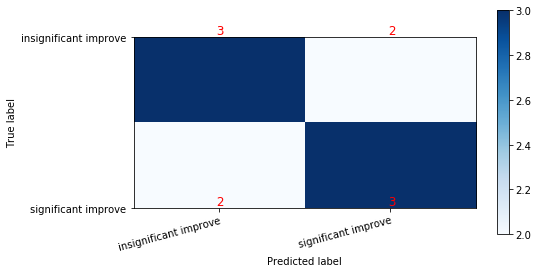

In [16]:
# get individual level confusion matrix using pred_results
# save the figure by giving it a name

plot_confusion_matrix(pred_re["improve_0.5"], pred_re["pred_0.5"])

In [17]:
# get individual level performance metrics
# choose a probability threshold to determine how high a probability will be judged as 1, otherwise 0 

proba_threshold = 0.5
model_performance_metrics(pred_re["improve_0.5"], pred_re["avg_proba"], proba_threshold)

           Leave one participant out test scores
Metrics                                         
Accuracy                                     0.6
Precision                                    0.6
Recall                                       0.6
f1-score                                     0.6


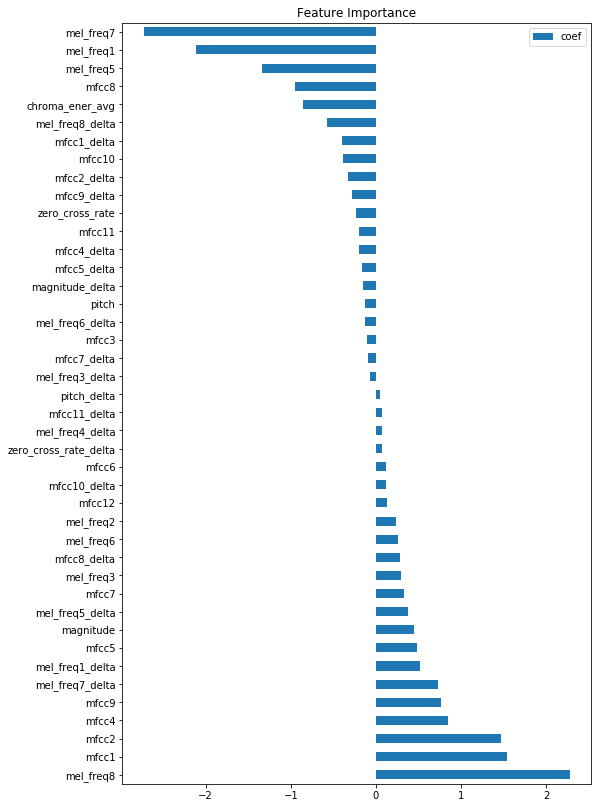

Percent number of features selected: 84.0 %

 ['mel_freq8', 'mfcc1', 'mfcc2', 'mfcc4', 'mfcc9', 'mel_freq7_delta', 'mel_freq1_delta', 'mfcc5', 'magnitude', 'mel_freq5_delta', 'mfcc7', 'mel_freq3', 'mfcc8_delta', 'mel_freq6', 'mel_freq2', 'mfcc12', 'mfcc10_delta', 'mfcc6', 'zero_cross_rate_delta', 'mel_freq4_delta', 'mfcc11_delta', 'pitch_delta', 'mel_freq3_delta', 'mfcc7_delta', 'mfcc3', 'mel_freq6_delta', 'pitch', 'magnitude_delta', 'mfcc5_delta', 'mfcc4_delta', 'mfcc11', 'zero_cross_rate', 'mfcc9_delta', 'mfcc2_delta', 'mfcc10', 'mfcc1_delta', 'mel_freq8_delta', 'chroma_ener_avg', 'mfcc8', 'mel_freq5', 'mel_freq1', 'mel_freq7']


In [18]:
# get feature importance by logistic regresison with ridge regularization 
# specify all feature names
# specify min_importance to set minimum importance of feature, feature with importance higher than min_importance will be selected
# if the figure by giving a name

all_feats = [i for i in df.columns if i not in ["Record Id", "improve_0.5"]]
min_importance=0.02 # domain=(0, 1)

# input classifier can be either cross validation or individual model
selected_feats = coef_importance(all_feats, avg_coef, min_importance)

# selected features can be used as input for other classifiers
print("\n", selected_feats)